(https://www.kaggle.com/c/ashrae-energy-prediction/)

# ASRAE - Modeling

In [209]:
import numpy as np
import pandas as pd


import seaborn as sns
import plotly as plt
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

from math import sqrt

import glob

import pandas_profiling as ppf
import sweetviz as sv
import missingno as msno

import pprint
import datetime
from math import sqrt

from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, train_test_split

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV


from prophet import Prophet

import xgboost as xgb

import pmdarima as pm
from pmdarima import model_selection
from pmdarima import pipeline
from pmdarima import preprocessing as ppc
from pmdarima import arima
from pmdarima.arima import ndiffs
from pmdarima.arima import ADFTest

print("pmdarima version: %s" % pm.__version__)

import tools as tl

sns.set(rc={'figure.figsize':(30,20)})

pd.options.display.float_format = '{:.2f}'.format

plt.rcParams.update({'font.size': 22})
sns.set(font_scale = 2)

import pprint
pp = pprint.PrettyPrinter(indent=4)

pmdarima version: 1.8.2


In [34]:
print(xgb.__version__)

1.4.2


In [35]:
pd.options.plotting.backend = "matplotlib"

In [36]:
pwd

'C:\\Users\\Mike\\Google Drive\\Code\\Springboard_Capstone_Energy'

## See Statistics written for each file (building-meter) combo

In [37]:
# See Building Statistics for missing data
df_stats = pd.read_csv('.//data_clean//building_reading_stats.csv')
# Keep only data that has at least 50 % of it
df_stats = df_stats[df_stats['per_data'] > 50.0]

In [38]:
df_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2245 entries, 0 to 2244
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   file_name                     2245 non-null   object 
 1   building                      2245 non-null   int64  
 2   meter                         2245 non-null   int64  
 3   len_train                     2245 non-null   int64  
 4   len_zero                      2245 non-null   int64  
 5   per_data                      2245 non-null   float64
 6   category                      2245 non-null   object 
 7   corr_meter_to_airtemp         2245 non-null   float64
 8   corr_meter_to_airtemp_wknd    2244 non-null   float64
 9   corr_meter_to_airtemp_wkdy    2245 non-null   float64
 10  corr_meter_to_airtemp_winter  2235 non-null   float64
 11  corr_meter_to_airtemp_spring  2228 non-null   float64
 12  corr_meter_to_airtemp_summer  2233 non-null   float64
 13  cor

In [39]:
# Modeling Choices
# Buildings with 1

In [40]:
# These represent buildings that are in top, mid and lower in square footage
lrg = [869, 1148, 375, 365, 269]
med = [1063, 1309, 991, 144, 693]
sm = [846, 621, 822, 816, 44]

# 0: Electricity 1: chilledwater 2: steam 3: hotwater

In [41]:
df_stats[(df_stats['building'] == 1148) & df_stats['meter'] == 1]

,file_name,building,meter,len_train,len_zero,per_data,category,corr_meter_to_airtemp,corr_meter_to_airtemp_wknd,corr_meter_to_airtemp_wkdy,corr_meter_to_airtemp_winter,corr_meter_to_airtemp_spring,corr_meter_to_airtemp_summer,corr_meter_to_airtemp_fall,square_feet,floor_count
194,1148_1.pkl,1148,1,8784,0,100.00,Office,0.78,0.79,0.79,0.21,0.74,0.45,0.76,861524,-1


In [42]:
# Examine building choices
df_stats[df_stats['building'] == 1148]

,file_name,building,meter,len_train,len_zero,per_data,category,corr_meter_to_airtemp,corr_meter_to_airtemp_wknd,corr_meter_to_airtemp_wkdy,corr_meter_to_airtemp_winter,corr_meter_to_airtemp_spring,corr_meter_to_airtemp_summer,corr_meter_to_airtemp_fall,square_feet,floor_count
193,1148_0.pkl,1148,0,8663,0,100.00,Office,-0.02,0.15,-0.04,-0.20,-0.11,-0.08,-0.08,861524,-1
194,1148_1.pkl,1148,1,8784,0,100.00,Office,0.78,0.79,0.79,0.21,0.74,0.45,0.76,861524,-1
902,1148_2.pkl,1148,2,8784,2,99.98,Office,-0.88,-0.86,-0.88,-0.83,-0.85,-0.43,-0.44,861524,-1


### Build list of files to include

In [43]:
# Get only the train data
direct = glob.glob('.\\data_clean\\buildings_by_meter\\' + '*.pkl')

directory = '.\\data_clean\\buildings_by_meter\\'
ext = '.pkl'

bld_mtr = ['1148_0']
files = []

# Build File names
for bm in bld_mtr:
    file_n = directory + bm + ext
    files.append(file_n)
        
files

['.\\data_clean\\buildings_by_meter\\1148_0.pkl']

In [44]:
df_sample = pd.read_pickle(files[0])
df_sample.head(1)

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,row_id,month,season,day_of_week,dayname,weekend
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01,1148,0,806.41,13,Office,861524,NaT,-1,-8.30,8.00,...,NaN,1023.30,250.00,4.10,NaN,1,1,4,Friday,0


# 1 - Build Model - ARIMA

In [ ]:
# Holes in the data
# Data is daily
offsets = [0,30,60] # offsets in days
data_sizes = [120]
test_sizes = [int(x * 0.25) for x in data_sizes]

resample = True
backfill = 'mean'
exogen = True

# For each of the file matches (did this way to prevent long run times)

# Dictionary to hold all the results, will turn into a dataframe
stats_all = {}

# For each file in the directory
for num,file in enumerate(files):
    # Termporary dictionary that represents a row
    stats = {}
    
    # Load Pickle for building - meter combination
    df_train = pd.read_pickle(file)
    
    # Load key variables in dictionary
    stats['building_id'] = df_train.iloc[0]['building_id']
    stats['square_feet'] = df_train.iloc[0]['square_feet']
    
    stats['meter'] = bldg_meter = df_train.iloc[0]['meter']
    stats['file_path'] = file
    
    stats['category'] = df_stats[(df_stats['building'] == stats['building_id']) & (df_stats['meter'] == stats['meter'])]['category'].iloc[0]
    stats['corr_meter_to_airtemp'] = df_stats[(df_stats['building'] == stats['building_id']) & (df_stats['meter'] == stats['meter'])]['corr_meter_to_airtemp'].iloc[0]    

#     df_train = pd.get_dummies(df_train)
#     print(df_train)
    
    # RESAMPLE DATA
    if resample:
        agg_dict={'meter_reading':'sum', 
                  'air_temperature':'max',
                  'dew_temperature':'max',
                  'cloud_coverage':'mean',
                  'dew_temperature':'max',
                  'precip_depth_1_hr':'sum',
                  'sea_level_pressure':'mean',
                  'building_id': 'max',
                  'site_id': 'max',
                  'square_feet': 'max',
                  'day_of_week':'max',
                  'weekend':'max',
                  'month':'max',
                  'season':'max'
                  }

        resamp = '1D'
        
        # Write Resample String
        stats['resample_period'] = resamp

        # Resample Dataframe
        df_train = df_train.resample(resamp).agg(agg_dict)
        
        # Drops
#         print(df_train.head())
        
    # Keep track of Models
    model_ctr = 1
    model_prefixes = []
    
    # Pull only training data
    
    # Curently for 4 periods data sizes is length, test_sizes is 0.25 % of that
    for ds, ts in zip(data_sizes,test_sizes):     
        for off in offsets:
            # Keep track of model prefix column names by building prefix to number iterations
            model_prefix = 'Model_' + str(model_ctr)
            model_prefixes.append(model_prefix)

            # df_slice is the total size of the set
            df_slice = df_train.iloc[off:off+ds]

            #df_slice.dropna(inplace=True)
            X_train, X_test, y_train, y_test = model_selection.train_test_split(df_slice.drop(labels=['meter_reading'],axis=1),
                                                                                df_slice['meter_reading'],test_size=ts)    

#             print('X Train')
#             print(X_train.columns)
#             print('X Test')
#             print(X_test)

#             print('Y Train')
#           print(y_train.columns)
#             print('Y Test')
#             print(y_test)
            
            # Fill Nas
            #Counts of null values 
            # Backfill with means
            if np.max(X_train.isnull().sum().sort_values(ascending=False)) > 0:
                stats[model_prefix + '_' + 'X_train_Backfill'] = backfill
                if backfill == 'mean':
                    X_train.fillna(X_train.mean(), inplace=True)
             
            # Backfill with mean
            if np.max(X_test.isnull().sum().sort_values(ascending=False)) > 0:
                stats[model_prefix + '_' + 'X_test_Backfill'] = backfill
                if backfill == 'mean':
                    X_test.fillna(X_test.mean(), inplace=True)
                
#             print(X_train)
         
            # Get rid of constants
            X_train.drop(labels=['site_id','building_id','square_feet'],axis=1,inplace=True)
            X_test.drop(labels=['site_id','building_id','square_feet'],axis=1,inplace=True)
           
            # Populate DataFrame with statistics
            stats[model_prefix + '_' + 'Type'] = 'ARIMA_Exogen'
            stats[model_prefix + '_' + 'DateStart'] = str(df_slice.iloc[0].name).split(" ")[0]
            stats[model_prefix + '_' + 'DateEnd'] = str(df_slice.iloc[-1].name).split(" ")[0]
            stats[model_prefix + '_' + 'DayOffset'] = off
            stats[model_prefix + '_' + 'DataSize'] = ds
            stats[model_prefix + '_' + 'TestSize'] = len(y_test)
#             stats[model_prefix + '_' + 'X_train_len'] = len(X_train)
#             stats[model_prefix + '_' + 'X_test_len'] = len(X_test)
            stats[model_prefix + '_' + 'y_train_len'] = len(y_train)
            stats[model_prefix + '_' + 'y_test_len'] = len(y_test)

#           ######################################    ARIMA   ##################################################
            print("\n" * 1)
            print('ARIMA Model: ')
            
            model = pm.auto_arima(y_train,X=X_train,trace=False,n_fits=10,seasonal=True,m=7,error_action='ignore')
#             print(model.summary())
            
            print('Prediction:')
            preds, conf_int = model.predict(X=X_test,n_periods=y_test.shape[0], return_conf_int=True)
            
            predict = pd.Series(preds,index=y_test.index)
#             conf_int = pd.Series(conf_int,index=y_test.index)
            
#             print(preds)
            df_result = pd.concat([predict,y_test],axis=1)
            df_result.columns = ['meter_predict_ARIMA','meter_actual']
            
            # display
            plt.figure(figsize=(20,10))
            plt.plot(df_result['meter_predict_ARIMA'],label="ARIMA")
            plt.plot(df_result['meter_actual'],label="Actual")
            plt.legend(loc = 'upper right')
            
#             plt.savefig('SecondPrection.jpg')
            plt.show()

            
            RMSE_error = (mean_squared_error(df_result['meter_predict_ARIMA'],df_result['meter_actual'],squared=False))
            print('RMSE: ' + str(RMSE_error))
            stats[model_prefix + '_' + 'RMSE'] = RMSE_error
            
            ######################################    PROPHET   ##################################################
        
    
            model_ctr += 1

            pp.pprint(stats)



ARIMA Model: 


# 2 - Build Model - Prophet

In [41]:
from prophet.plot import plot_plotly, plot_components_plotly

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


-----------------------------------------------------------------------------
     building  meter  per_data category  square_feet  corr_meter_to_airtemp
193      1148      0    100.00   Office       861524                  -0.02
Data Size:  120
Train Size:  30
Offset:  0


DATA
Date Start: 
2016-01-01 00:00:00
Date End: 
2016-04-29 00:00:00


TRAIN
Date Start: 
2016-01-01 00:00:00
Date End: 
2016-03-30 00:00:00


TEST
Date Start: 
2016-03-31 00:00:00
Date End: 
2016-04-29 00:00:00
           ds    trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2016-03-31 23613.50    19838.98    32068.03     23613.50     23613.50   
1  2016-04-01 23650.21    17848.71    29433.29     23650.21     23650.21   
2  2016-04-02 23686.92    13982.24    27085.56     23686.92     23686.92   
3  2016-04-03 23723.62    13929.70    26706.76     23723.62     23723.62   
4  2016-04-04 23760.33    18604.96    31186.21     23760.33     23760.33   
5  2016-04-05 23797.04    19159.79    31567.35     23797.

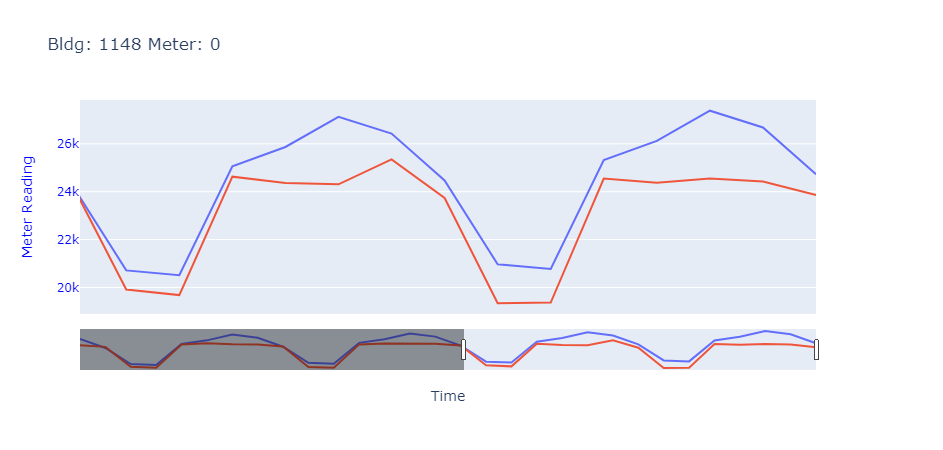

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 1358.2544995061937
Data Size:  120
Train Size:  30
Offset:  30


DATA
Date Start: 
2016-01-31 00:00:00
Date End: 
2016-05-29 00:00:00


TRAIN
Date Start: 
2016-01-31 00:00:00
Date End: 
2016-04-29 00:00:00


TEST
Date Start: 
2016-04-30 00:00:00
Date End: 
2016-05-29 00:00:00
           ds    trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2016-04-30 23047.32    19403.44    20128.76     23047.03     23047.32   
1  2016-05-01 23046.60    19098.05    19870.49     23043.33     23049.35   
2  2016-05-02 23045.88    24085.92    24838.58     23037.02     23053.94   
3  2016-05-03 23045.15    24293.33    25081.29     23028.89     23061.12   
4  2016-05-04 23044.43    24151.43    24877.69     23020.69     23069.36   
5  2016-05-05 23043.71    24153.11    24900.00     23010.05     23078.25   
6  2016-05-06 23042.99    23490.42    24263.06     23000.48     23088.05   
7  2016-05-07 23042.27    19353.58    20132.25     22988.88     23096.41   
8  2016-05-08 23041.55    19076.30

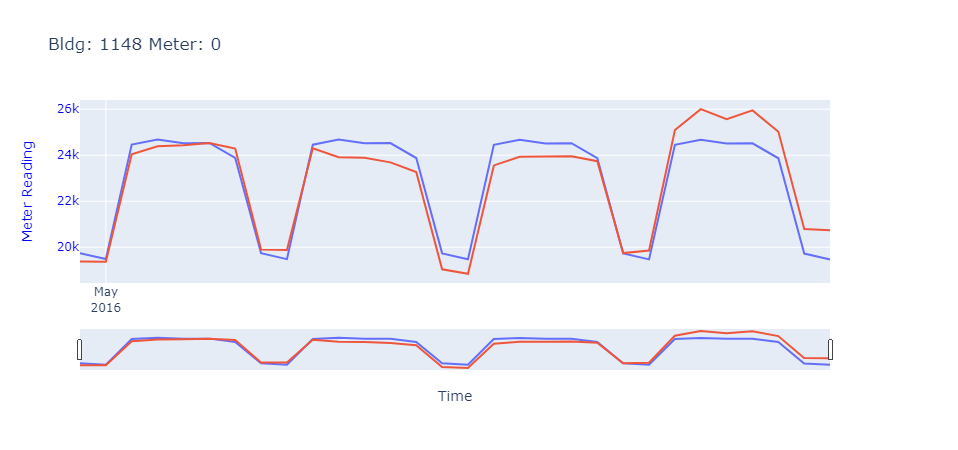

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 715.2630863459896
Data Size:  120
Train Size:  30
Offset:  60


DATA
Date Start: 
2016-03-01 00:00:00
Date End: 
2016-06-28 00:00:00


TRAIN
Date Start: 
2016-03-01 00:00:00
Date End: 
2016-05-29 00:00:00


TEST
Date Start: 
2016-05-30 00:00:00
Date End: 
2016-06-28 00:00:00
           ds    trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  2016-05-30 24073.23    24957.07    25951.94     24072.68     24074.16   
1  2016-05-31 24151.31    25306.46    26343.63     24146.46     24157.36   
2  2016-06-01 24229.39    25205.91    26218.68     24217.92     24245.11   
3  2016-06-02 24307.47    25284.86    26322.70     24286.22     24333.59   
4  2016-06-03 24385.55    24727.22    25756.38     24351.13     24421.44   
5  2016-06-04 24463.63    20639.22    21685.87     24412.99     24511.35   
6  2016-06-05 24541.71    20488.37    21516.51     24481.03     24603.28   
7  2016-06-06 24619.79    25513.82    26522.05     24542.61     24698.67   
8  2016-06-07 24697.87    25879.08 

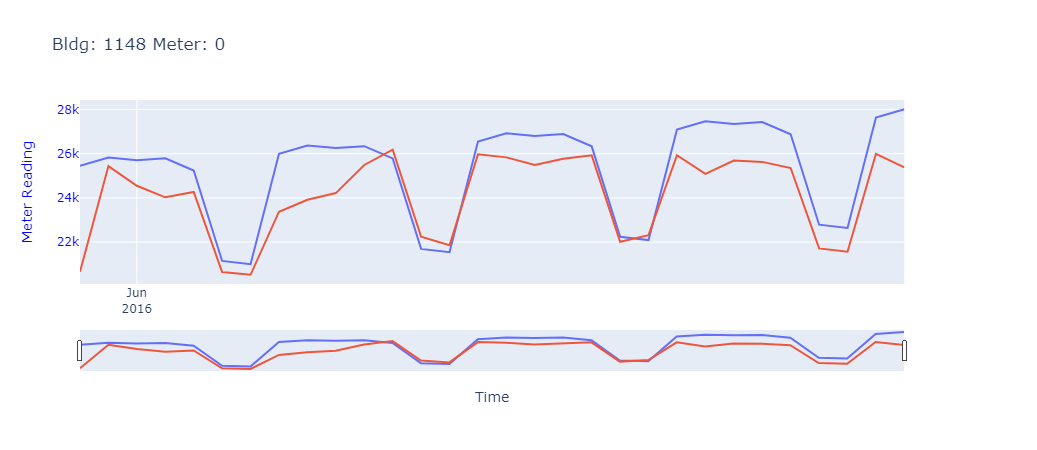

MSE: 1626.9604657932443


In [83]:
# Holes in the data
# Data is daily
offsets = [0,30,60] # offsets in days
data_sizes = [120]
test_sizes = [int(x * 0.25) for x in data_sizes]

resample = True

# For each of the file matches (did this way to prevent long run times)
for num,file in enumerate(files):
    print('-----------------------------------------------------------------------------')
 
    df_train = pd.read_pickle(file) # Show how many days 
    
    bldg_size = df_train.iloc[0]['square_feet']
    bldg_number = df_train.iloc[0]['building_id']
    bldg_meter = df_train.iloc[0]['meter']

    title = df_stats[(df_stats['building'] == bldg_number) & (df_stats['meter'] == bldg_meter)][['building',
                                                                                                 'meter',
                                                                                                 'per_data',
                                                                                                'category',
                                                                                                'square_feet',
                                                                                       'corr_meter_to_airtemp']]
    print(title)
 
    if resample:
    #     # Map of how we aggregate new data when it is resampled
        agg_dict={'meter_reading':'sum', 
                  'air_temperature':'max',
                  'dew_temperature':'max',
                  'cloud_coverage':'mean',
                  'dew_temperature':'max',
                  'precip_depth_1_hr':'sum',
                  'sea_level_pressure':'mean',
                  'building_id': 'max',
                  'site_id': 'max'
                  }

        resamp = '1D'

        df_train = df_train.resample(resamp).agg(agg_dict)

    # Curently for 4 periods
    for ds, ts in zip(data_sizes,test_sizes):     
        for off in offsets:
            print('Data Size: ', ds)
            print('Train Size: ', ts)
            print('Offset: ', off)
            
            df_train = df_train.iloc[off:off+ds]

            X_train, X_test, y_train, y_test = model_selection.train_test_split(df_train.loc[:, df_cols.columns != 'meter_reading'], df_test['meter_reading'] test_size=ts)
            df_slice = df_train.iloc[off:off+ds]
            
            print("\n" * 1)
            print('DATA')
            print('Date Start: ')
            print(df_slice.iloc[0].name)
            print('Date End: ')
            print(df_slice.iloc[-1].name)
            
            print("\n" * 1)
            print('TRAIN')
            print('Date Start: ')
            print(train.iloc[0].name)
            print('Date End: ')
            print(train.iloc[-1].name)
            
            print("\n" * 1)
            print('TEST')
            print('Date Start: ')
            print(test.iloc[0].name)
            print('Date End: ')
            print(test.iloc[-1].name)
            
            
            ######################################    PROPHET   ##################################################

            m = Prophet()
            df_prophet_train = train.reset_index()

            df_prophet_train = df_prophet_train[['timestamp','meter_reading']]
            df_prophet_train = df_prophet_train.rename(columns={'timestamp':'ds','meter_reading':'y'})

            test2 = test
            df_prophet_test = test.reset_index()
            df_prophet_test = df_prophet_test[['timestamp','meter_reading']]
            df_prophet_test = df_prophet_test.rename(columns={'timestamp':'ds','meter_reading':'y'})

            df_prophet_predict = test.reset_index()
            df_prophet_predict = df_prophet_predict[['timestamp']]
            df_prophet_predict = df_prophet_predict.rename(columns={'timestamp':'ds'})

            
            m.fit(df_prophet_train)
            
            predicts = m.predict(df_prophet_test)
            print(predicts)

             ######################################   VISUALIZE #################################################
            subfig = make_subplots(specs=[[{"secondary_y": True}]])
            
            fig = px.line(predicts, x='ds', y='yhat', 
                           title='Bldg: ' + str(bldg_number) + ' ' + 'Meter: ' + str(bldg_meter))
            
            fig2 = px.line(test2, x=test2.index, y='meter_reading', 
                           title='Bldg: ' + str(bldg_number) + ' ' + 'Meter: ' + str(bldg_meter))

            fig2.update_traces(yaxis="y1")

            subfig.add_traces(fig.data + fig2.data)
            subfig.layout.title='Bldg: ' + str(bldg_number) + ' ' + 'Meter: ' + str(bldg_meter)
            subfig.layout.xaxis.title="Time"
            subfig.layout.yaxis.title="Meter Reading"
            subfig.layout.yaxis.color="blue"

            subfig.update_xaxes(dtick="M1", tickformat="%b\n%Y")

            subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color)))
            subfig.update_xaxes(rangeslider_visible=True)
            

            # Hover text for exploration
            subfig.update_traces(mode='lines',hovertemplate="%{x|%Y/%m/%d %a %H:%M:%S.%L} value: %{y}")
            subfig.update_layout(showlegend=True)
            subfig.write_image('.//visualization//' + str(bldg_number) + '_' + str(bldg_meter) + 'Prophet.jpg')

            subfig.show()
            
            error = ((sqrt(mean_squared_error(predicts['yhat'],test2['meter_reading']))))
            print('MSE: ' + str(error))
    

# 3 - Build Model - XGBoost

In [12]:
# Holes in the data
# Data is daily
offsets = [0,30,60] # offsets in days
data_sizes = [120]
test_sizes = [int(x * 0.25) for x in data_sizes]

resample = True

# For each of the file matches (did this way to prevent long run times)
for num,file in enumerate(files):
    print('-----------------------------------------------------------------------------')
 
    # Load File
    df_train = pd.read_pickle(file) # Show how many days 
    
    # Get BLDG Size
    bldg_size = df_train.iloc[0]['square_feet']
    # Get BLDG Id
    bldg_number = df_train.iloc[0]['building_id']
    # Get Meter Size
    bldg_meter = df_train.iloc[0]['meter']

    title = df_stats[(df_stats['building'] == bldg_number) & (df_stats['meter'] == bldg_meter)][['building',
                                                                                                 'meter',
                                                                                                 'per_data',
                                                                                                'category',
                                                                                                'square_feet',
                                                                                       'corr_meter_to_airtemp']]
    print(title)
 
    # Resample
    if resample:
    #     # Map of how we aggregate new data when it is resampled
        agg_dict={'meter_reading':'sum', 
                  'air_temperature':'max',
                  'dew_temperature':'max',
                  'cloud_coverage':'mean',
                  'dew_temperature':'max',
                  'precip_depth_1_hr':'sum',
                  'sea_level_pressure':'mean',
                  'building_id': 'max',
                  'site_id': 'max'
                  }
        
        # Resamp period
        resamp = '1D'

        df_train = df_train.resample(resamp).agg(agg_dict)

    # Curently for 4 periods
    for ds, ts in zip(data_sizes,test_sizes):     
        for off in offsets:
            print('Data Size: ', ds)
            print('Train Size: ', ts)
            print('Offset: ', off)

            X_train, X_test  = model_selection.train_test_split(df_train.iloc[off:off+ds], test_size=ts)
            df_slice = df_train.iloc[off:off+ds]
            
            print("\n" * 1)
            print('DATA')
            print('Date Start: ')
            print(df_slice.iloc[0].name)
            print('Date End: ')
            print(df_slice.iloc[-1].name)
            
            print("\n" * 1)
            print('TRAIN')
            print('Date Start: ')
            print(train.iloc[0].name)
            print('Date End: ')
            print(train.iloc[-1].name)
            
            print("\n" * 1)
            print('TEST')
            print('Date Start: ')
            print(test.iloc[0].name)
            print('Date End: ')
            print(test.iloc[-1].name)
            
            # Train is a dataframe
            
             ######################################    XGBOOST   ##################################################
             
            # Instantiate Model
            gbm = xgb.XGBRegressor(objective = 'reg:linear', n_estimators = 10, seed = 123)
 
            train_X = train['air_temperature'].reset_index(drop=True)
            train_y = train['meter_reading'].reset_index()
            test_X = test['air_temperature'].reset_index()
            test_y = test['meter_reading'].reset_index()
#             train_X = np.array(train['air_temperature'].fillna(0).values).reshape(1,-1)
#             train_y = np.array(train['meter_reading'].fillna(0).values).reshape(1,-1)
#             test_X = np.array(test['air_temperature'].fillna(0).values).reshape(1,-1)
#             test_y = np.array(train['meter_reading'].fillna(0).values).reshape(1,-1)
            
#             print(train['air_temperature'])
            

            print(train_X)
        
        
            # Fitting the Model
            gbm.fit(train_X,train_y)
            pred = gbm.predict(train_X, train_y)

            # RMSE Computation
            rmse = np.sqrt(MSE(test_X, pred))
            print("RMSE : % f" %(rmse))

             ######################################   VISUALIZE #################################################
#             subfig = make_subplots(specs=[[{"secondary_y": True}]])
            
#             fig = px.line(predicts, x='ds', y='yhat', 
#                            title='Bldg: ' + str(bldg_number) + ' ' + 'Meter: ' + str(bldg_meter))
            
#             fig2 = px.line(test2, x=test2.index, y='meter_reading', 
#                            title='Bldg: ' + str(bldg_number) + ' ' + 'Meter: ' + str(bldg_meter))

#             fig2.update_traces(yaxis="y1")

#             subfig.add_traces(fig.data + fig2.data)
#             subfig.layout.title='Bldg: ' + str(bldg_number) + ' ' + 'Meter: ' + str(bldg_meter)
#             subfig.layout.xaxis.title="Time"
#             subfig.layout.yaxis.title="Meter Reading"
#             subfig.layout.yaxis.color="blue"

#             subfig.update_xaxes(dtick="M1", tickformat="%b\n%Y")

#             subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color)))
#             subfig.update_xaxes(rangeslider_visible=True)
            

#             # Hover text for exploration
#             subfig.update_traces(mode='lines',hovertemplate="%{x|%Y/%m/%d %a %H:%M:%S.%L} value: %{y}")
#             subfig.update_layout(showlegend=True)
#             subfig.write_image('.//visualization//' + str(bldg_number) + '_' + str(bldg_meter) + 'Prophet.jpg')

#             subfig.show()
            
#             error = ((sqrt(mean_squared_error(predicts['yhat'],test2['meter_reading']))))
#             print('MSE: ' + str(error))

NameError: name 'files' is not defined

3 - Build Model XGBoost

## Time Series Split Cross Validation

In [ ]:
tss =  TimeSeriesSplit(n_splits=4,gap=4,test_size=14,max_train_size=120) #too generic
rmse = []
count = 1

results = pd.DataFrame()


# Write function that rolls next pd.delta?

for train_index, test_index in tss.split(df_train): 
    
    cv_train, cv_test = df_train.iloc[train_index]['meter_reading'], df_train.iloc[test_index]['meter_reading']
    model = pm.auto_arima(cv_train,trace=True,n_fits=20)
    print(model.summary())
    
    # 
    predicts = model.predict(n_periods=14)
    true_values = cv_test.values
    error = ((sqrt(mean_squared_error(predicts,true_values))))
    model.plot_diagnostics()
    rmse.append(error)
    print(error)
print('RMSE')
print(np.mean(rmse))

In [ ]:
df_tyra
print(model.summary())

# 
predicts = model.predict(n_periods=14)
true_values = cv_test.values
error = ((sqrt(mean_squared_error(predicts,true_values))))
model.plot_diagnostics()
rmse.append(error)
print(error)

In [ ]:
train.plot()

In [ ]:
test.plot()

In [ ]:
model.predict(n_periods=20)

In [ ]:

#                      start_p=1,max_p=7,
#                      start_q=1,max_q=7,
#                      start_P=1,max_P=7,
#                      start_Q=1,max_Q=7,
preds = model.predict(n_periods=test.shape[0], return_conf_int=False)

# cv = model_selection.SlidingWindowForecastCV(window_size=3,step=1,h=4)
# predictions = model_selection.cross_val_predict(model, test, cv=cv, verbose=2, averaging='median')
# # temp_model_cv_scores = model_selection.cross_val_score(model, train, scoring='smape', cv=cv, verbose=2)

# pred = pd.Series(predictions)
# df_temp_preds = pd.DataFrame(pred,index=test.index,columns=['predictions'])
# df_preds =pd.concat([df_temp_preds,test],axis=1)
# df_preds

# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds)))


# Plot Forecasts
x_axis = np.arange(train.shape[0] + preds.shape[0])
x_years = x_axis + 2016  # Year starts at 1821

plt.plot(preds,kind='line')

In [ ]:

model.plot_diagnostics()

In [ ]:
model

In [ ]:
preds

In [ ]:
model

In [ ]:
preds

In [ ]:
df_temp_preds = pd.DataFrame(preds,index=test.index,columns=['predictions'])
df_preds =pd.concat([df_temp_preds,test],axis=1)
df_preds

In [ ]:
# Plot Forecasts
x_axis = np.arange(train.shape[0] + preds.shape[0])
x_years = x_axis + 2016  # Year starts at 1821

plt.plot(df_preds,kind='line')

# plt.fill_between(x_years[x_axis[-preds.shape[0]:]],
#                  conf_int[:, 0], conf_int[:, 1],
#                  alpha=0.1, color='b')
# plt.title("Temperature Forecast")
# plt.xlabel("Year")

# ARIMA

### Set PDQ

# Rolling Forecast ARIMA
### Walk-forward validation

### Grid Search ARIMA / Evaluation

# Facebook Prophet
## Additive Time Series Forecasting Model

In [ ]:
from fbprophet import Prophet

In [ ]:
data_len = 366
split_test_doy = 270

df_train = df.iloc[0:split_test_doy]
df_test = df.iloc[split_test_doy:data_len]

In [ ]:
df_prophet_train = df_train.reset_index()
df_prophet_train = df_prophet_train[['timestamp','meter_reading']]
df_prophet_train = df_prophet_train.rename(columns={'timestamp':'ds','meter_reading':'y'})

df_prophet_test = df_test.reset_index()
df_prophet_test = df_prophet_test[['timestamp','meter_reading']]
df_prophet_test = df_prophet_test.rename(columns={'timestamp':'ds','meter_reading':'y'})

df_prophet_predict = df_test.reset_index()
df_prophet_predict = df_prophet_predict[['timestamp']]
df_prophet_predict = df_prophet_predict.rename(columns={'timestamp':'ds'})


In [ ]:
model = Prophet()
model.fit(df_prophet_train)

In [ ]:
df_forecast = model.predict(df_prophet_predict)

In [ ]:
print(df_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

In [ ]:
model.plot(forecast)